FASTA format function from problem description:

In [1]:
def read_fasta_file(filename):
    """
    Reads the given FASTA file f and returns a dictionary of sequences.

    Lines starting with ';' in the FASTA file are ignored.
    """
    sequences_lines = {}
    current_sequence_lines = None
    with open(filename) as fp:
        for line in fp:
            line = line.strip()
            if line.startswith(';') or not line:
                continue
            if line.startswith('>'):
                sequence_name = line.lstrip('>')
                current_sequence_lines = []
                sequences_lines[sequence_name] = current_sequence_lines
            else:
                if current_sequence_lines is not None:
                    current_sequence_lines.append(line)
    sequences = {}
    for name, lines in sequences_lines.items():
        sequences[name] = ''.join(lines)
    return sequences

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

genome = ''
annotation = ''
for i in range(1,6):
    genome += read_fasta_file('data/genome%d.fa' % i)['genome%d' % i]
    annotation += read_fasta_file('data/annotation%d.fa' % i)['annotation%d' % i]

print(len(genome), len(annotation))

11045066 11045066


C fra R
R fra C
R fra C
R fra C


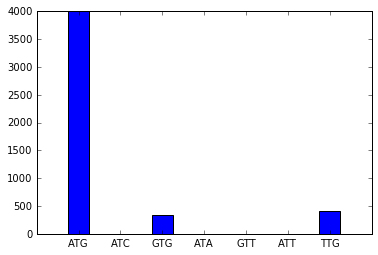

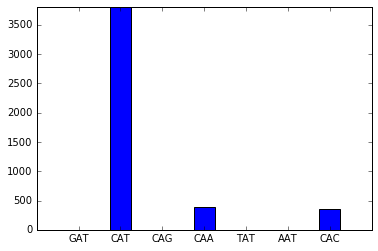

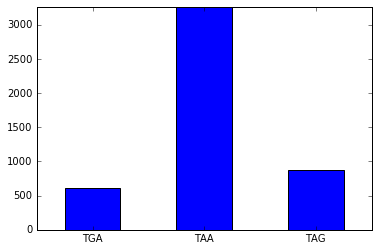

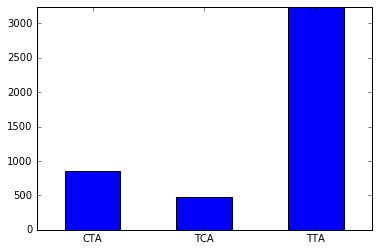

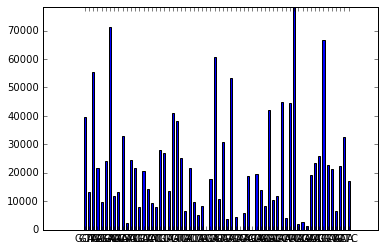

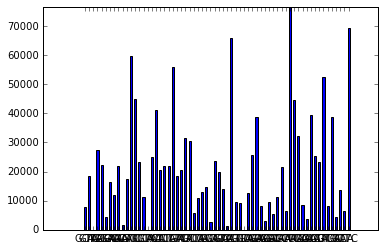

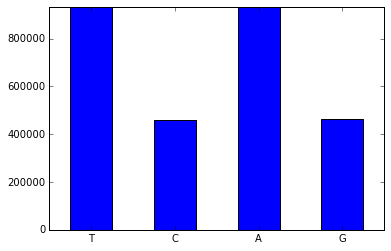

In [3]:
def addCodon(codon, start, stop, content):
    if len(codon) >= 1:
        start[codon[0]] += 1
        if len(codon[1:-1]) < 1:
            print('tis')
        for c in codon[1:-1]:
            content[c] += 1
        stop[codon[-1]] += 1


def hist_from_dict(d):
    plt.figure()
    X = np.arange(len(d))
    plt.bar(X, d.values(), align='center', width=0.5)
    plt.xticks(X, d.keys())
    ymax = max(d.values()) + 1
    plt.ylim(0, ymax)
    plt.show()

C_start = defaultdict(lambda: 0)
C_stop = defaultdict(lambda: 0)
C_content = defaultdict(lambda: 0)

R_start = defaultdict(lambda: 0)
R_stop = defaultdict(lambda: 0)
R_content = defaultdict(lambda: 0)

N_content = defaultdict(lambda: 0)

state = 'N'
i = 0
gene = list()
while i < len(annotation):
    if annotation[i] == 'C':
        if state == 'R':
            print('C fra R')
            addCodon(gene, R_start, R_stop, R_content)
            gene = list()
        state = 'C'
        gene.append(genome[i:i+3])
        i += 3
    elif annotation[i] == 'R':
        if state == 'C':
            print('R fra C')
            addCodon(gene, C_start, C_stop, C_content)
            gene = list()
        state = 'R'
        gene.append(genome[i:i+3])
        i += 3
    else:
        if state != 'N':
            if state == 'C':
                addCodon(gene, C_start, C_stop, C_content)
            elif state == 'R':
                addCodon(gene, R_start, R_stop, R_content)
            gene = list()
            state = 'N'
        N_content[genome[i]] += 1
        i = i+1

        
hist_from_dict(C_start)
hist_from_dict(R_stop)

hist_from_dict(C_stop)
hist_from_dict(R_start)

hist_from_dict(C_content)
hist_from_dict(R_content)
hist_from_dict(N_content)

    

In [4]:

alphabet = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
def emissionProb(d):
    n = len(list(d.keys())[0]) 
    emissions = np.zeros([n, 4])
    sum = 0
    for key, value in d.items():
        for i in range(n):
            emissions[i, alphabet[key[i]]] += value
        sum += value
    emissions /= sum
    return emissions
    
print(emissionProb(N_content))


[[ 0.33434315  0.16479453  0.16612728  0.33473505]]


In [7]:
countings = (N_content, # 0
            C_start,    # 1-3
            C_content,  # 4-6
            C_stop,     # 7-9
            R_start,    # 10-12
            R_content,  # 13-15
            R_stop)     # 16-18

emission = np.zeros([0, 4])
for count in countings:
    emission = np.vstack([emission, emissionProb(count)])
    
#print(emission)
n_states = emission.shape[0]
#print(n_states)

A = np.zeros([n_states, n_states]) # pseudo counting!

A[0,0] = sum(N_content.values())
A[0,1] = sum(C_start.values())

A[1,2] = sum(C_start.values())
A[2,3] = sum(C_start.values())
A[3,4] = sum(C_start.values()) #obs

A[4,5] = sum(C_content.values())
A[5,6] = sum(C_content.values())
A[6,4] = sum(C_content.values()) - sum(C_start.values())

A[6,7] = sum(C_stop.values())
A[7,8] = sum(C_stop.values())
A[8,9] = sum(C_stop.values())
A[9,0] = sum(C_stop.values())



# R
A[0,10] = sum(R_start.values())

A[10,11] = sum(R_start.values())
A[11,12] = sum(R_start.values())
A[12,13] = sum(R_start.values()) #obs

A[13,14] = sum(R_content.values())
A[14,15] = sum(R_content.values())
A[15,13] = sum(R_content.values()) - sum(R_start.values())

A[15,16] = sum(R_stop.values())
A[16,17] = sum(R_stop.values())
A[17,18] = sum(R_stop.values())
A[18,0] = sum(R_stop.values())


print(A)
print('A sum')
print(A.sum(axis=1))
print('A')
A /= A.sum(axis=1)[:,None]
print(A)

# sanity check
if (np.rint(1000*A.sum(axis=1)) != 1000).all():
    print('hvad laver du!?=?!?!')

[[ 2788964.     4752.        0.        0.        0.        0.        0.
         0.        0.        0.     4565.        0.        0.        0.
         0.        0.        0.        0.        0.]
 [       0.        0.     4752.        0.        0.        0.        0.
         0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.        0.]
 [       0.        0.        0.     4752.        0.        0.        0.
         0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.        0.]
 [       0.        0.        0.        0.     4752.        0.        0.
         0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.  1377294.        0.
         0.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.        0.]
 [       0.    

In [56]:
print(C_start['ATG'])
print(C_content['ATG'])
print(N_content['ATG'])

print(C_content['TAA'])
print(C_content['TAG'])
print(C_content['TGA'])


4010
30719
47317
23
9
3


In [ ]:
Hypoteser:
    Længden af sekvenser med C eller R er altid et multiplum af 3
    